In [128]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import math, tqdm
import seaborn as sns
from lib.model import MLP, RNN_LSTM, RNN_ILSTM, RNN_SLSTM
from lib.data import FlatData, MNIST_add_data
from lib.utils import timeSince
from lib.train import TrainMLP
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from lib.evaluation import Evaluation, plot_confusion, plot_train_val, plot_train_val_multiple
from lib.data import TwoStateMNISTData
from lib.utils import random_split_dataset
import random
import torch.backends.cudnn as cudnn
import warnings
import glob
from lib.train import Train

In [2]:
root = './mnist_data'
use_gpu = None
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
trainval_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
train_proportion = 0.8
train_set, val_set = random_split_dataset(trainval_set, [train_proportion, 1-train_proportion])
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

In [115]:
n_hidden = 30 # 50, 300
n_categories = 10
seed = 42

if seed is not None:
    random.seed(seed)
    torch.manual_seed(seed)
    cudnn.deterministic = True
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')
    
'''StateMNISTData vanilla'''
min_length, max_length = 5, 5
target_function = torch.cat([torch.randperm(n_categories).unsqueeze(0) for _ in range(max_length)], 0)

'''ShiftStateMNISTData'''
'''
offset = [-1,3,5,-2,3]
min_length, max_length = 5, 5
'''

/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: You have chosen to seed training. This will turn on the CUDNN deterministic setting, which can slow down your training considerably! You may see unexpected behavior when restarting from checkpoints.
  if __name__ == '__main__':


'\noffset = [-1,3,5,-2,3]\nmin_length, max_length = 5, 5\n'

In [116]:
target_function

tensor([[2, 6, 1, 8, 4, 5, 0, 9, 3, 7],
        [3, 5, 8, 9, 4, 6, 1, 0, 7, 2],
        [7, 5, 0, 3, 1, 6, 9, 8, 4, 2],
        [9, 2, 5, 1, 4, 3, 7, 0, 8, 6],
        [9, 6, 2, 4, 1, 7, 5, 3, 0, 8]])

In [5]:
from lib.data import StateMNISTData

savename_tr = 'sequence_data/train.pkl'
savename_val = 'sequence_data/val.pkl'
savename_te = 'sequence_data/test.pkl'
n_tr = 10000
n_val = 3000
n_te = 10000

train_data = StateMNISTData(train_set)
train_data.set_seq_length(min_length=min_length, max_length=max_length)
train_data.set_target_function(target_function)
train_data.save_data(savename_tr, n_tr)

val_data = StateMNISTData(val_set)
val_data.set_seq_length(min_length=min_length, max_length=max_length)
val_data.set_target_function(target_function)
val_data.save_data(savename_val, n_val)

test_data = StateMNISTData(test_set)
test_data.set_seq_length(min_length=min_length, max_length=max_length)
test_data.set_target_function(target_function)
test_data.save_data(savename_te, n_te)

==>save data of size 10000 in sequence_data/train.pkl
==>save data done
==>load data sequence_data/train.pkl
==>load data of size 10000 done
==>save data of size 3000 in sequence_data/val.pkl
==>save data done
==>load data sequence_data/val.pkl
==>load data of size 3000 done
==>save data of size 10000 in sequence_data/test.pkl
==>save data done
==>load data sequence_data/test.pkl
==>load data of size 10000 done


### multi output LSTM

In [8]:
from lib.model import RNN_LSTM
from lib.train import TrainMORNN

net = RNN_LSTM(784, n_hidden, n_categories)
savename = 'mo_models/lstm.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 10%
             31|             0%|          0m 7s|        0.01372|        0.00000|        2.25920
             62|             1%|          0m 7s|        0.01282|        0.00000|        2.20824
             93|             2%|          0m 8s|        0.01195|        0.00000|        2.15976
            124|             3%|          0m 8s|        0.01159|        0.00000|        2.11815
            155|             4%|          0m 8s|        0.01113|        0.00000|        2.08084
            186|             5%|          0m 9s|        0.01083|        0.00000|        2.05006
            217|             6%|          0m 9s|        0.01075|        0.00000|        2.01852
            248|             7%|          0m 9s|        0.01064|        0.00000|        1.98909
            279|             8%|          0m 9s|        0.01055|      

           2480|            79%|         1m 22s|        0.00979|        0.00000|        1.15963
==> evaluating validation accuracy
==> validation accuracy is 77%
           2511|            80%|         1m 29s|        0.00979|        0.00000|        1.15388
           2542|            81%|         1m 29s|        0.00980|        0.00000|        1.14753
           2573|            82%|         1m 30s|        0.00980|        0.00000|        1.14138
           2604|            83%|         1m 30s|        0.00981|        0.00000|        1.13549
           2635|            84%|         1m 30s|        0.00981|        0.00000|        1.12953
           2666|            85%|         1m 30s|        0.00982|        0.00000|        1.12354
           2697|            86%|         1m 31s|        0.00984|        0.00000|        1.11774
           2728|            87%|         1m 31s|        0.00985|        0.00000|        1.11220
           2759|            88%|         1m 31s|        0.00985|      

In [10]:
from lib.model import RNN_MLP
from lib.train import TrainMORNN

net = RNN_MLP(784, n_hidden, n_categories)
savename = 'mo_models/mlp.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 14%
             31|             0%|          0m 8s|        0.01162|        0.00000|        2.18692
             62|             1%|          0m 9s|        0.01141|        0.00000|        2.09409
             93|             2%|          0m 9s|        0.01101|        0.00000|        2.05035
            124|             3%|          0m 9s|        0.01089|        0.00000|        2.02576
            155|             4%|          0m 9s|        0.01058|        0.00000|        2.00202
            186|             5%|         0m 10s|        0.01039|        0.00000|        1.98063
            217|             6%|         0m 10s|        0.01039|        0.00000|        1.96594
            248|             7%|         0m 10s|        0.01060|        0.00000|        1.95622
            279|             8%|         0m 11s|        0.01077|      

           2480|            79%|         1m 34s|        0.01028|        0.00000|        1.83842
==> evaluating validation accuracy
==> validation accuracy is 27%
           2511|            80%|         1m 43s|        0.01029|        0.00000|        1.83807
           2542|            81%|         1m 43s|        0.01029|        0.00000|        1.83767
           2573|            82%|         1m 43s|        0.01030|        0.00000|        1.83696
           2604|            83%|         1m 44s|        0.01032|        0.00000|        1.83662
           2635|            84%|         1m 44s|        0.01033|        0.00000|        1.83637
           2666|            85%|         1m 44s|        0.01033|        0.00000|        1.83617
           2697|            86%|         1m 45s|        0.01034|        0.00000|        1.83596
           2728|            87%|         1m 45s|        0.01034|        0.00000|        1.83555
           2759|            88%|         1m 45s|        0.01029|      

accuracy is 28.60%


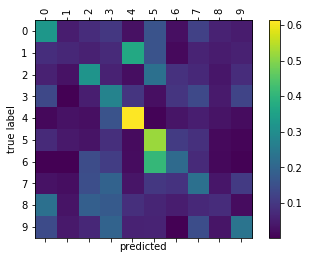

In [11]:
from lib.evaluation import Evaluation
n_categories = 10

evaluation = Evaluation(net, test_data, use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### MoW

In [12]:
from lib.model import RNN_LSTM_MoW
from lib.train import TrainMORNN

net = RNN_LSTM_MoW(784, n_hidden, n_categories)
net.setKT(2,max_length)
savename = 'mo_models/lstm_mow.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy


/data/jiaxuan/sequence_fun/lib/model.py:46: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  o, hidden = self.model(x, hidden)


==> validation accuracy is 12%
             31|             0%|         0m 34s|        0.06660|        0.00000|        2.26984
             62|             1%|         0m 37s|        0.06847|        0.00000|        2.21522
             93|             2%|         0m 39s|        0.06822|        0.00000|        2.15710
            124|             3%|         0m 41s|        0.06913|        0.00000|        2.09749
            155|             4%|         0m 43s|        0.06945|        0.00000|        2.03920
            186|             5%|         0m 45s|        0.06916|        0.00000|        1.98240
            217|             6%|         0m 47s|        0.06798|        0.00000|        1.92482
            248|             7%|         0m 49s|        0.06813|        0.00000|        1.87057
            279|             8%|         0m 51s|        0.06841|        0.00000|        1.81752
            310|             9%|         0m 54s|        0.06831|        0.00000|        1.76733
==> evalu

==> validation accuracy is 89%
           2511|            80%|         7m 59s|        0.06793|        0.00000|        0.65664
           2542|            81%|          8m 1s|        0.06791|        0.00000|        0.65181
           2573|            82%|          8m 3s|        0.06796|        0.00000|        0.64690
           2604|            83%|          8m 5s|        0.06798|        0.00000|        0.64232
           2635|            84%|          8m 7s|        0.06798|        0.00000|        0.63780
           2666|            85%|         8m 10s|        0.06800|        0.00000|        0.63331
           2697|            86%|         8m 12s|        0.06803|        0.00000|        0.62894
           2728|            87%|         8m 14s|        0.06799|        0.00000|        0.62467
           2759|            88%|         8m 16s|        0.06800|        0.00000|        0.62052
           2790|            89%|         8m 18s|        0.06797|        0.00000|        0.61645
==> evalu

In [13]:
from lib.model import RNN_MLP_MoW
from lib.train import TrainMORNN

net = RNN_MLP_MoW(784, n_hidden, n_categories)
net.setKT(2,5)
savename = 'mo_models/mlp_mow.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 11%
             31|             0%|         0m 22s|        0.05063|        0.00000|        2.19511
             62|             1%|         0m 24s|        0.04754|        0.00000|        2.09936
             93|             2%|         0m 25s|        0.04515|        0.00000|        2.02700
            124|             3%|         0m 26s|        0.04544|        0.00000|        1.96275
            155|             4%|         0m 28s|        0.04639|        0.00000|        1.90355
            186|             5%|         0m 29s|        0.04650|        0.00000|        1.85646
            217|             6%|         0m 31s|        0.04657|        0.00000|        1.81360
            248|             7%|         0m 32s|        0.04603|        0.00000|        1.77431
            279|             8%|         0m 34s|        0.04635|      

           2480|            79%|         4m 48s|        0.04568|        0.00000|        0.92716
==> evaluating validation accuracy
==> validation accuracy is 77%
           2511|            80%|         5m 12s|        0.04569|        0.00000|        0.92394
           2542|            81%|         5m 14s|        0.04571|        0.00000|        0.92041
           2573|            82%|         5m 15s|        0.04576|        0.00000|        0.91705
           2604|            83%|         5m 16s|        0.04576|        0.00000|        0.91373
           2635|            84%|         5m 18s|        0.04577|        0.00000|        0.91082
           2666|            85%|         5m 19s|        0.04569|        0.00000|        0.90802
           2697|            86%|         5m 21s|        0.04571|        0.00000|        0.90505
           2728|            87%|         5m 22s|        0.04573|        0.00000|        0.90221
           2759|            88%|         5m 24s|        0.04574|      

In [14]:
torch.nn.functional.softmax(net.coef, 1)

tensor([[0.2286, 0.7714],
        [0.5015, 0.4985],
        [0.7251, 0.2749],
        [0.0333, 0.9667],
        [0.9611, 0.0389]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### shared 

In [15]:
from lib.model import RNN_SLSTM
from lib.train import TrainMORNN

net = RNN_SLSTM(784, n_hidden, n_categories)
net.set_shared_groups([[0,1,2], [3, 4]])
savename = 'mo_models/lstm_shared.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 13%
             31|             0%|         0m 15s|        0.01704|        0.00000|        2.23476
             62|             1%|         0m 15s|        0.01625|        0.00000|        2.14949
             93|             2%|         0m 16s|        0.01580|        0.00000|        2.06899
            124|             3%|         0m 16s|        0.01569|        0.00000|        1.99290
            155|             4%|         0m 17s|        0.01554|        0.00000|        1.92385
            186|             5%|         0m 17s|        0.01568|        0.00000|        1.86036
            217|             6%|         0m 18s|        0.01553|        0.00000|        1.80530
            248|             7%|         0m 18s|        0.01554|        0.00000|        1.75494
            279|             8%|         0m 18s|        0.01546|      

           2480|            79%|         2m 29s|        0.01525|        0.00000|        0.67655
==> evaluating validation accuracy
==> validation accuracy is 89%
           2511|            80%|         2m 44s|        0.01527|        0.00000|        0.67202
           2542|            81%|         2m 44s|        0.01523|        0.00000|        0.66717
           2573|            82%|         2m 45s|        0.01525|        0.00000|        0.66269
           2604|            83%|         2m 45s|        0.01525|        0.00000|        0.65816
           2635|            84%|         2m 46s|        0.01525|        0.00000|        0.65369
           2666|            85%|         2m 46s|        0.01525|        0.00000|        0.64919
           2697|            86%|         2m 47s|        0.01524|        0.00000|        0.64487
           2728|            87%|         2m 47s|        0.01523|        0.00000|        0.64068
           2759|            88%|         2m 47s|        0.01523|      

In [16]:
from lib.model import RNN_SMLP
from lib.train import TrainMORNN

net = RNN_SMLP(784, n_hidden, n_categories)
net.set_shared_groups([[0,1,2], [3, 4]])
savename = 'mo_models/mlp_shared.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 18%
             31|             0%|          0m 9s|        0.01074|        0.00000|        2.10262
             62|             1%|          0m 9s|        0.01087|        0.00000|        1.92811
             93|             2%|          0m 9s|        0.01076|        0.00000|        1.81193
            124|             3%|         0m 10s|        0.01102|        0.00000|        1.73709
            155|             4%|         0m 10s|        0.01033|        0.00000|        1.68524
            186|             5%|         0m 10s|        0.00973|        0.00000|        1.64152
            217|             6%|         0m 11s|        0.01031|        0.00000|        1.60738
            248|             7%|         0m 11s|        0.01038|        0.00000|        1.57969
            279|             8%|         0m 11s|        0.01025|      

           2480|            79%|         1m 39s|        0.01069|        0.00000|        1.33065
==> evaluating validation accuracy
==> validation accuracy is 42%
           2511|            80%|         1m 47s|        0.01070|        0.00000|        1.32980
           2542|            81%|         1m 48s|        0.01070|        0.00000|        1.32914
           2573|            82%|         1m 48s|        0.01069|        0.00000|        1.32847
           2604|            83%|         1m 48s|        0.01070|        0.00000|        1.32773
           2635|            84%|         1m 49s|        0.01070|        0.00000|        1.32707
           2666|            85%|         1m 49s|        0.01063|        0.00000|        1.32657
           2697|            86%|         1m 49s|        0.01057|        0.00000|        1.32598
           2728|            87%|         1m 49s|        0.01057|        0.00000|        1.32541
           2759|            88%|         1m 50s|        0.01059|      

### independent

In [17]:
from lib.model import RNN_ILSTM
from lib.train import TrainMORNN

net = RNN_ILSTM(784, n_hidden, n_categories)
net.set_max_length(max_length)
savename = 'mo_models/lstm_independent.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 14%
             31|             0%|         0m 14s|        0.01418|        0.00000|        2.16261
             62|             1%|         0m 15s|        0.01738|        0.00000|        1.99866
             93|             2%|         0m 15s|        0.01755|        0.00000|        1.85210
            124|             3%|         0m 16s|        0.01740|        0.00000|        1.72259
            155|             4%|         0m 16s|        0.01745|        0.00000|        1.61172
            186|             5%|         0m 17s|        0.01734|        0.00000|        1.51307
            217|             6%|         0m 17s|        0.01740|        0.00000|        1.42728
            248|             7%|         0m 18s|        0.01737|        0.00000|        1.35310
            279|             8%|         0m 18s|        0.01716|      

           2480|            79%|         2m 35s|        0.01712|        0.00000|        0.41622
==> evaluating validation accuracy
==> validation accuracy is 90%
           2511|            80%|         2m 49s|        0.01716|        0.00000|        0.41333
           2542|            81%|         2m 50s|        0.01719|        0.00000|        0.41033
           2573|            82%|         2m 50s|        0.01719|        0.00000|        0.40761
           2604|            83%|         2m 51s|        0.01719|        0.00000|        0.40482
           2635|            84%|         2m 51s|        0.01718|        0.00000|        0.40193
           2666|            85%|         2m 52s|        0.01719|        0.00000|        0.39921
           2697|            86%|         2m 52s|        0.01718|        0.00000|        0.39660
           2728|            87%|         2m 53s|        0.01719|        0.00000|        0.39397
           2759|            88%|         2m 53s|        0.01719|      

In [18]:
from lib.model import RNN_IMLP
from lib.train import TrainMORNN

net = RNN_IMLP(784, n_hidden, n_categories)
net.set_max_length(max_length)
savename = 'mo_models/mlp_independent.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

trainer = TrainMORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 11%
             31|             0%|          0m 8s|        0.01239|        0.00000|        1.95293
             62|             1%|          0m 9s|        0.01236|        0.00000|        1.63584
             93|             2%|          0m 9s|        0.01205|        0.00000|        1.39469
            124|             3%|          0m 9s|        0.01170|        0.00000|        1.22753
            155|             4%|         0m 10s|        0.01204|        0.00000|        1.10774
            186|             5%|         0m 10s|        0.01223|        0.00000|        1.01622
            217|             6%|         0m 11s|        0.01228|        0.00000|        0.94454
            248|             7%|         0m 11s|        0.01248|        0.00000|        0.88713
            279|             8%|         0m 12s|        0.01256|      

           2480|            79%|         1m 40s|        0.01237|        0.00000|        0.36644
==> evaluating validation accuracy
==> validation accuracy is 88%
           2511|            80%|         1m 49s|        0.01234|        0.00000|        0.36516
           2542|            81%|         1m 50s|        0.01235|        0.00000|        0.36369
           2573|            82%|         1m 50s|        0.01236|        0.00000|        0.36222
           2604|            83%|         1m 51s|        0.01237|        0.00000|        0.36105
           2635|            84%|         1m 51s|        0.01237|        0.00000|        0.35985
           2666|            85%|         1m 51s|        0.01237|        0.00000|        0.35885
           2697|            86%|         1m 52s|        0.01238|        0.00000|        0.35768
           2728|            87%|         1m 52s|        0.01237|        0.00000|        0.35655
           2759|            88%|         1m 53s|        0.01238|      

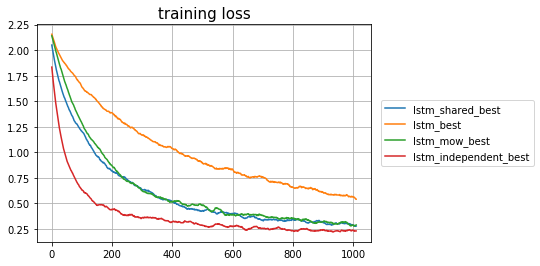

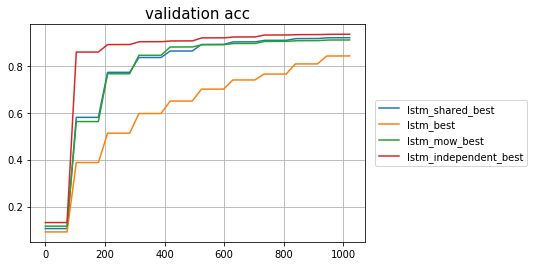

In [56]:
#plot_train_val(["mo_models/repeat/1/*_best*"]) # 3 shared groups of 3 identical tasks, different tasks different output permutation, same length (9)
plot_train_val(["mo_models/samples/lstm*_best*"]) # 5 independent tasks, same length (5)

The plots shows following properties:
1. Without memory, no single model can fit all time steps: MLP is failing (gray curve)
2. With memory, a model struggles to switch to the correct time step model: LSTM is failing (green curve)
3. Independent models does well with no shared tasks (brown and pink curves, bottom)
4. Shared lstm and mow lstm does about the same (orange and red curves)
5. Shared mlp does worse than mow mlp even though shared model is given the correct structure (blue and purple curve, above)

### plot multiple runs

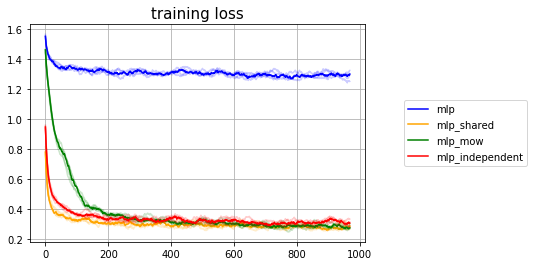

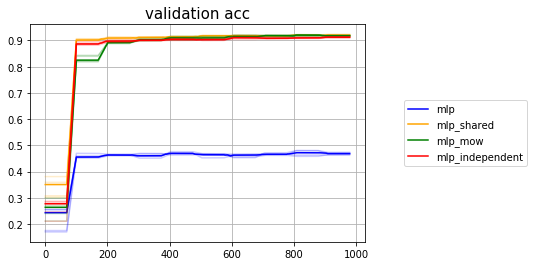

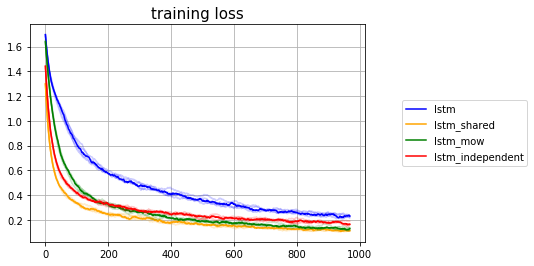

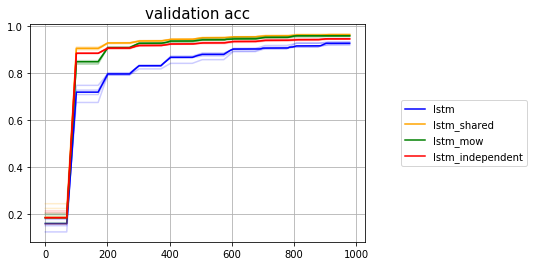

In [66]:
datadir = 'mo_models/vary_repeat/*/'

mlp_models = ['mlp.p*',
              'mlp_shared.p*',
              'mlp_mow.p*',
              'mlp_independent.p*']
rnn_models = ['lstm.p*',
              'lstm_shared.p*',
              'lstm_mow.p*',
              'lstm_independent.p*']
mlp_models = [os.path.join(datadir, m) for m in mlp_models]
rnn_models = [os.path.join(datadir, m) for m in rnn_models]
                         
plot_train_val_multiple(mlp_models)
plot_train_val_multiple(rnn_models)